# An Analysis of Opening Moves

This notebook analyses the opening moves of agents.

## Imports

In [1]:
import random
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize

import Arena
from MCTS import MCTS
from blooms.BloomsGame import BloomsGame
from blooms.BloomsPlayers import *
from blooms.pytorch.NNet import NNetWrapper as NNet
from utils import *

## Setup Game and Agent

In [2]:
# WARNING: The game size and score target should match the chosen agent
game = BloomsGame(size=4, score_target=15)
opponent = RandomPlayer(game).play

# WARNING: The chosen agent should match the game size and score target
model = NNet(game)
model.load_checkpoint('./results/chkpts_board4_24hrs/', 'best.pth.tar')
args = dotdict({'numMCTSSims': 100, 'cpuct': 4.0})
mcts = MCTS(game, model, args)
agent = lambda x: np.argmax(mcts.getActionProb(x, temp=0))

## Inspect Opening Move in a Sample of Games

In [10]:
SAMPLE_SIZE = 100

board = game.getInitBoard()
moves = []
for _ in range(SAMPLE_SIZE):
    move_idx = agent(game.getCanonicalForm(board, 1))
    moves.append(board.move_map_player_1.inverse[move_idx])

In [13]:
position_counts = np.zeros((2 * board.size - 1, 2 * board.size - 1))
for move in moves:
    for action in move:
        if action:
            q, r = action[0], action[1]
            position_counts[r, q] += 1
            
position_counts

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [14]:
normalised_position_counts = position_counts / np.max(position_counts)
normalised_position_counts

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

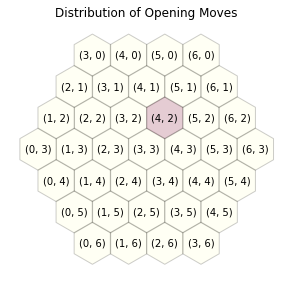

In [27]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_aspect('equal')

for q in range(0, normalised_position_counts.shape[-1]):
    for r in range(0, normalised_position_counts.shape[-1]):
        if board.is_valid_space((q, r)):
            x, y = board.axial_to_pixel(q, r)
            colour = cm.YlOrRd(normalised_position_counts[r, q])
            hexagon = RegularPolygon((x, y),
                                     numVertices=6,
                                     radius=1.75 * np.sqrt(1 / 3),
                                     alpha=0.2,
                                     edgecolor='k',
                                     facecolor=colour)
            ax.add_patch(hexagon)

            ax.annotate(text=f'({q}, {r})',
                        xy=(x, y),
                        ha='center',
                        va='center')

plt.title("Distribution of Opening Moves")

plt.xticks([])
plt.yticks([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)


plt.gca().invert_yaxis()
plt.autoscale(enable=True)
plt.show()

## Inspect Opening Responding Move in a Sample of Games

In [3]:
SAMPLE_SIZE = 100

moves = []
for _ in range(SAMPLE_SIZE):
    board = game.getInitBoard()
    
    random_move = random.choice(list(board.move_map_player_1.keys()))
    while random_move[1]:
        random_move = random.choice(list(board.move_map_player_1.keys()))
    
    board.execute_move(random_move, 1)
    
    move_idx = agent(game.getCanonicalForm(board, -1))
    moves.append(board.move_map_player_1.inverse[move_idx])

In [4]:
response_position_counts = np.zeros((2 * board.size - 1, 2 * board.size - 1))
for move in moves:
    for action in move:
        if action:
            q, r = action[0], action[1]
            response_position_counts[r, q] += 1
            
response_position_counts

array([[ 0.,  0.,  0.,  5.,  5.,  0.,  0.],
       [ 0.,  0.,  2., 13.,  6.,  8.,  4.],
       [ 0.,  6.,  5.,  8., 12.,  3.,  1.],
       [ 7.,  3.,  9., 24.,  4.,  6.,  1.],
       [ 2.,  3.,  3., 11.,  5.,  0.,  0.],
       [ 2.,  5.,  4.,  6.,  4.,  0.,  0.],
       [ 6.,  4.,  2.,  3.,  0.,  0.,  0.]])

In [5]:
normalised_response_position_counts = response_position_counts / np.sum(response_position_counts)
normalised_response_position_counts

array([[0.        , 0.        , 0.        , 0.02604167, 0.02604167,
        0.        , 0.        ],
       [0.        , 0.        , 0.01041667, 0.06770833, 0.03125   ,
        0.04166667, 0.02083333],
       [0.        , 0.03125   , 0.02604167, 0.04166667, 0.0625    ,
        0.015625  , 0.00520833],
       [0.03645833, 0.015625  , 0.046875  , 0.125     , 0.02083333,
        0.03125   , 0.00520833],
       [0.01041667, 0.015625  , 0.015625  , 0.05729167, 0.02604167,
        0.        , 0.        ],
       [0.01041667, 0.02604167, 0.02083333, 0.03125   , 0.02083333,
        0.        , 0.        ],
       [0.03125   , 0.02083333, 0.01041667, 0.015625  , 0.        ,
        0.        , 0.        ]])

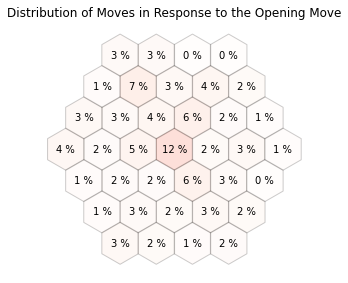

In [6]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_aspect('equal')

for q in range(0, normalised_response_position_counts.shape[-1]):
    for r in range(0, normalised_response_position_counts.shape[-1]):
        if board.is_valid_space((q, r)):
            x, y = board.axial_to_pixel(q, r)
            colour = cm.Reds(normalised_response_position_counts[r, q] / np.max(response_position_counts) * 100)
            hexagon = RegularPolygon((x, y),
                                     numVertices=6,
                                     radius=1.75 * np.sqrt(1 / 3),
                                     alpha=0.2,
                                     edgecolor='k',
                                     facecolor=colour)
            ax.add_patch(hexagon)

            ax.annotate(text=f'{normalised_response_position_counts[r, q] * 100:.0f} %',
                        xy=(x, y),
                        ha='center',
                        va='center')

plt.title("Distribution of Moves in Response to the Opening Move")

plt.xticks([])
plt.yticks([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)


plt.gca().invert_yaxis()
plt.autoscale(enable=True)
plt.savefig('outputs/board4_opening_response_moves_distribution.pdf')
plt.show()